## A/B Test Data analysis

In [1]:
# import packages
import numpy as np
import pandas as pd
import scipy.stats as stats
from statsmodels.stats import proportion as proptests
import matplotlib.pyplot as plt
% matplotlib inline


from IPython.display import Markdown, display, HTML
def printmd(string):
    display(Markdown(string))


UsageError: Line magic function `%` not found.


In [9]:
# import data
df = pd.read_csv('homepage-experiment-data.csv')
display(df)

print(df.shape)

,Day,Control Cookies,Control Downloads,Control Licenses,Experiment Cookies,Experiment Downloads,Experiment Licenses
0,1,1764,246,1,1850,339,3
1,2,1541,234,2,1590,281,2
2,3,1457,240,1,1515,274,1
3,4,1587,224,1,1541,284,2
4,5,1606,253,2,1643,292,3
5,6,1681,287,3,1780,299,3
6,7,1534,262,5,1555,276,8
7,8,1798,331,12,1787,326,20
8,9,1478,223,30,1553,298,38
9,10,1461,236,32,1458,289,23


(29, 7)


## Check invariant metrics

### The number of cookies assigned to each group

### A) Use Bootstrapping

In [10]:
# Get dataframe with all records from control group
control_num_cookies = df['Control Cookies'].sum()
control_num_cookies

46851

In [11]:
# Get dataframe with all records from experiment group
experiment_num_cookies = df['Experiment Cookies'].sum()
experiment_num_cookies

47346

In [12]:
# Compute the observed difference in number cookies
obs_diff = experiment_num_cookies - control_num_cookies
obs_diff

495

In [13]:
# Create a sampling distribution of the difference in proportions
# with bootstrapping
diffs = []
size = df.shape[0]
for _ in range(10000):
    b_samp = df.sample(size, replace=True)
    control_num_cookies = b_samp['Control Cookies'].sum()
    experiment_num_cookies = b_samp['Experiment Cookies'].sum()
    diffs.append(experiment_num_cookies - control_num_cookies)

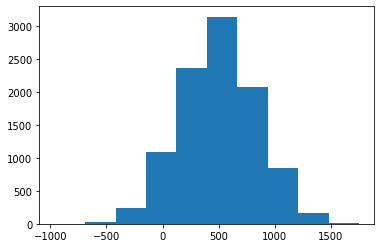

In [14]:
# Convert to numpy array
diffs = np.array(diffs)
# Plot sampling distribution
plt.hist(diffs);

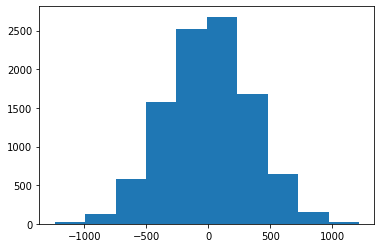

In [16]:
#Simulate distribution under the null hypothesis
null_vals = np.random.normal(0, diffs.std(), diffs.size)
# Plot the null distribution
plt.hist(null_vals);

0.0748

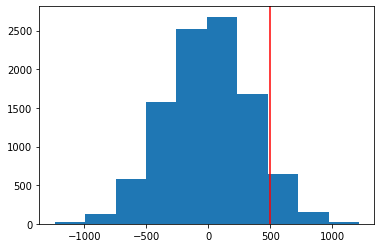

In [17]:
# Plot observed statistic with the null distibution
plt.hist(null_vals);
plt.axvline(obs_diff, c='red')

# Compute p-value
(null_vals > obs_diff).mean()

In [ ]:
# Result: We fail reject the Null hypothesis at type I error of 5%
# The number of cookies assigned to each group is an invariant metric

### B) Rank-Sum Test (Mann-Whitney)

In [19]:
def ranked_sum(x, y, alternative = 'two-sided'):
    """
    Return a p-value for a ranked-sum test, assuming no ties.
    
    Input parameters:
        x: 1-D array-like of data for first group
        y: 1-D array-like of data for second group
        alternative: type of test to perform, {'two-sided', less', 'greater'}
    
    Output value:
        p: estimated p-value of test
    """
    
    # compute U
    u = 0
    for i in x:
        wins = (i > y).sum()
        ties = (i == y).sum()
        u += wins + 0.5 * ties
    
    # compute a z-score
    n_1 = x.shape[0]
    n_2 = y.shape[0]
    mean_u = n_1 * n_2 / 2
    sd_u = np.sqrt( n_1 * n_2 * (n_1 + n_2 + 1) / 12 )
    z = (u - mean_u) / sd_u
    
    # compute a p-value
    if alternative == 'two-sided':
        p = 2 * stats.norm.cdf(-np.abs(z))
    if alternative == 'less':
        p = stats.norm.cdf(z)
    elif alternative == 'greater':
        p = stats.norm.cdf(-z)
    
    return p

0.743171653420498

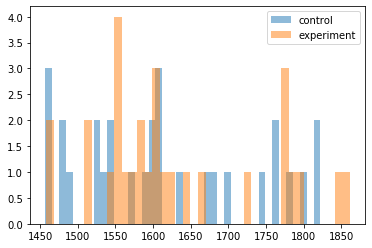

In [27]:
# data visualization
bin_borders = 40
plt.hist(df['Control Cookies'], alpha = 0.5, bins = bin_borders)
plt.hist(df['Experiment Cookies'], alpha = 0.5, bins = bin_borders)
plt.legend(labels = ['control', 'experiment']);

ranked_sum(df['Control Cookies'],
       df['Experiment Cookies'],
       alternative = 'greater')

In [ ]:
# Result: We fail reject the Null hypothesis at type I error of 5%
# The number of cookies assigned to each group is an invariant metric

### C) Sign Test

In [29]:
def sign_test(x, y, alternative = 'two-sided'):
    """
    Return a p-value for a ranked-sum test, assuming no ties.
    
    Input parameters:
        x: 1-D array-like of data for first group
        y: 1-D array-like of data for second group
        alternative: type of test to perform, {'two-sided', less', 'greater'}
    
    Output value:
        p: estimated p-value of test
    """
    
    # compute parameters for Binominal distribution, subtract events where there is no value difference
    n = x.shape[0] - (x == y).sum()
    k = (x > y).sum() - (x == y).sum()

    # compute a p-value
    if alternative == 'two-sided':
        p = min(1, 2 * stats.binom(n, 0.5).cdf(min(k, n-k)))
    if alternative == 'less':
        p = stats.binom(n, 0.5).cdf(k)
    elif alternative == 'greater':
        p = stats.binom(n, 0.5).cdf(n-k)
    
    return p


No handles with labels found to put in legend.


0.35553555190563196

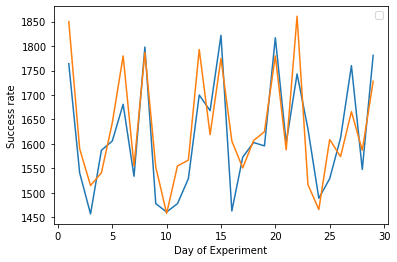

In [30]:
# data visualization
plt.plot(df['Day'], df['Control Cookies'])
plt.plot(df['Day'], df['Experiment Cookies'])
plt.legend()

plt.xlabel('Day of Experiment')
plt.ylabel('Success rate');

sign_test(df['Control Cookies'], df['Experiment Cookies'], 'less')

In [ ]:
# Result: We fail reject the Null hypothesis at type I error of 5%
# The number of cookies assigned to each group is an invariant metric

## Check Evaluation metrics

### A) Bootsrapping

In [46]:
# Get dataframe with all records from control group
control_download_rate = (df['Control Downloads'] / df['Control Cookies']).mean()
control_purchase_rate = (df['Control Licenses'] / df['Control Cookies']).mean()

In [47]:
# Get dataframe with all records from experiment group
experiment_download_rate = (df['Experiment Downloads'] / df['Experiment Cookies']).mean()
experiment_purchase_rate = (df['Experiment Licenses'] / df['Experiment Cookies']).mean()

In [48]:
# Compute the observed difference 
obs_diff_download_rate= (experiment_download_rate - control_download_rate)

obs_diff_purchase_rate= (experiment_purchase_rate - control_purchase_rate)
print(obs_diff_download_rate)
print(obs_diff_purchase_rate)

0.019584883323598645
0.0003728065154907194


In [56]:
# Create a sampling distribution of the difference in proportions
# with bootstrapping
diffs_download = []
diffs_purchase = []
size = df.shape[0]
for _ in range(100000):
    b_samp = df.sample(size, replace=True)
    control_download_rate = (b_samp['Control Downloads'] / b_samp['Control Cookies']).mean()
    control_purchase_rate = (b_samp['Control Licenses'] / b_samp['Control Cookies']).mean()    
    experiment_download_rate = (b_samp['Experiment Downloads'] / b_samp['Experiment Cookies']).mean()
    experiment_purchase_rate = (b_samp['Experiment Licenses'] / b_samp['Experiment Cookies']).mean() 
                             
    diffs_download.append(experiment_download_rate - control_download_rate)
    diffs_purchase.append(experiment_purchase_rate - control_purchase_rate)

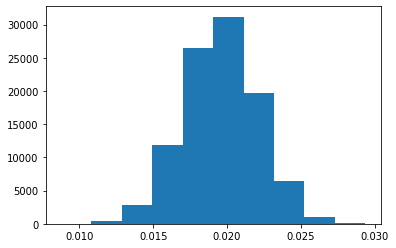

In [57]:
# Convert to numpy array
diffs = np.array(diffs_download)
# Plot sampling distribution
plt.hist(diffs);

0.0

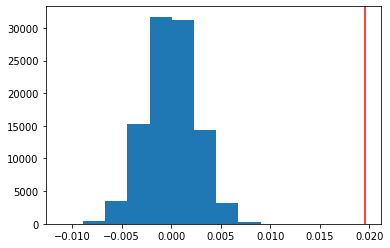

In [58]:
# Simulate distribution under the null hypothesis
null_vals = np.random.normal(0, diffs.std(), diffs.size)

# Plot observed statistic with the null distibution
plt.hist(null_vals);
plt.axvline(obs_diff_download_rate, c='red')

# Compute p-value
(null_vals > obs_diff_download_rate).mean()

In [59]:
# Result: We have evidence to reject the Null hypothesis

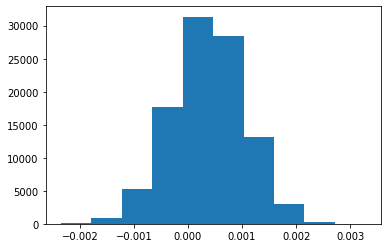

In [60]:
# Convert to numpy array
diffs = np.array(diffs_purchase)
# Plot sampling distribution
plt.hist(diffs);

0.28931

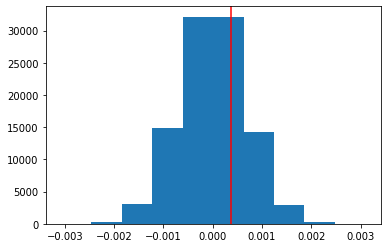

In [61]:
# Simulate distribution under the null hypothesis
null_vals = np.random.normal(0, diffs.std(), diffs.size)

# Plot observed statistic with the null distibution
plt.hist(null_vals);
plt.axvline(obs_diff_purchase_rate, c='red')

# Compute p-value
(null_vals > obs_diff_purchase_rate).mean()

In [62]:
# Result: We have no evidence to reject the Null hypothesis